Object detection is a difficult task; modern approaches to the problem require deep convolutional networks with tens of billions of floating point operations per detection. However, in many cases we can simplify the problem of object detection and use a faster, more compact model to identify the target object.

In this tutorial, we will use a method known as color thresholding to detect an object of a particular hue. We will see that this method is robust to elastic deformation, partial occlusion, scaling, rotation, and a small range of lighting conditions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

In order to detect our object, we need to know its color. We will quantify the color using HSV's hue component.

In [2]:
# The base hue used for thresholding
base_hue = 0

# The callback used by our trackbar to adjust the base_hue
def update_hue(new_hue):
    global base_hue
    base_hue = new_hue

To determine our object's hue, we will:<br/>
1) Convert a frame of the webcam stream to HSV<br/>
2) Create a mask by applying color thresholding to the H channel<br/>
3) Repeat with varying base_hue settings until the mask is as accurate as possible

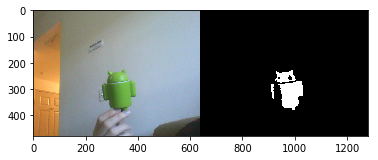

In [3]:
# Open a VideoCapture object using the webcam
cap = cv2.VideoCapture(0)

# Create a window with a trackbar for adjusting the base_hue
cv2.namedWindow('Window')
cv2.createTrackbar('Hue', 'Window', 0, 179, update_hue)

# Read frames, create masks, and display until the user presses 's'
while True:
    # Read a frame
    capped, frame = cap.read()
    if not capped:
        print('[ERROR] Failed to read next frame')
        break
    
    # Convert frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Define range for hue thresholding
    # (H-10, 100, 100) to (H+10, 255, 255) is a good starting point
    lower_bound = (base_hue - 10, 100, 100)
    upper_bound = (base_hue + 10, 255, 255)
    
    # Apply color thresholding to obtain object mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Create a 3-channel mask image so it can be hstacked with the BGR frame
    mask_3channels = cv2.merge([mask, mask, mask])
    combo_image = np.hstack([frame, mask_3channels])
    
    # Make a copy of the combined image to draw text on and display
    display_image = combo_image.copy()
    cv2.putText(display_image, "Press 's' to save this hue:", (0, 25), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 255, 0))
    
    # Display our image
    cv2.imshow('Window', display_image)
    
    # Wait 30ms for user to press a key; break loop if user presses 's'
    key = cv2.waitKey(30)
    if key == ord('s'):
        break
    
# Close all OpenCV windows and free VideoCapture's resources
cv2.destroyAllWindows()
cap.release()

# Display combined image in matplotlib (expects RGB, not BGR, so we convert)
plt.imshow(cv2.cvtColor(combo_image, cv2.COLOR_BGR2RGB))

Now that the base hue of the mask is saved, we can improve the mask quality using basic morphological operations.

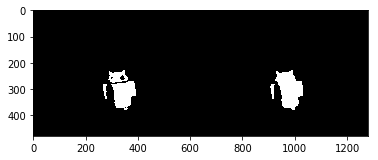

In [4]:
# Create a 5x5 elliptical structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Apply some "close" morphologies to the mask, filling in the holes for a better-connected mask
mask_morphed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=kernel, iterations=3)

# Horizontally stack the un-morphed and morphed masks for display
mask_before_and_after = np.hstack([mask, mask_morphed])

# Display masks (bitwise_not to ensure white foreground on black background)
plt.imshow(cv2.bitwise_not(mask_before_and_after), cmap='binary')

Now that we have an improved mask, we can find contours with OpenCV and use them to generate a bounding box for our object.

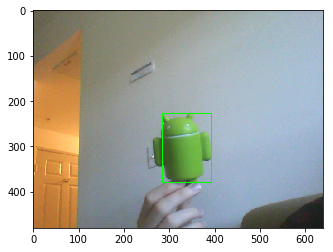

In [5]:
# Find external contours
_, cnts, _ = cv2.findContours(mask_morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Set (arbitrary) minimum contour area for detection, to avoid false positives
min_contour_area = 300

if len(cnts) > 0:
    # Find largest contour in frame
    max_area_contour = max(cnts, key=cv2.contourArea)
    
    if cv2.contourArea(max_area_contour) > min_contour_area:
        # Draw bounding box around largest contour
        (x, y, w, h) = cv2.boundingRect(max_area_contour)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Now, let's put it all together into a real-time object detector.

In [6]:
cap = cv2.VideoCapture(0)

# New boundaries after tuning
# My object was often too dark to detect fully, so I decreased the saturation and value lower bounds.
lower_bound = (base_hue - 10, 75, 25)
upper_bound = (base_hue + 10, 255, 255)

while True:
    # Read in a frame
    capped, frame = cap.read()
    if not capped:
        print('[ERROR] Failed to read frame')
        break
    
    # Convert frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Apply color thresholding to generate a mask for our desired color range
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Apply morphologies to improve the mask quality
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_morphed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=kernel, iterations=3)
    # I added some "open" operations to reduce the amount of noise
    mask_morphed = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel=kernel, iterations=3)
    
    # Find external contours
    _, cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Tuned minimum contour area
    min_contour_area = 1000
    
    if len(cnts) > 0:
        # Find largest contour
        max_area_contour = max(cnts, key=cv2.contourArea)
        
        if cv2.contourArea(max_area_contour) > min_contour_area:
            # Draw bounding box for largest contour
            (x, y, w, h) = cv2.boundingRect(max_area_contour)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    cv2.imshow('Detector', frame)
    
    # Wait 30ms for user to press a key; break loop when any key is pressed
    if cv2.waitKey(30) != -1:
        break
    
cv2.destroyAllWindows()
cap.release()